# Detect duplication in the dataset

In [1]:
import sys
sys.path.append("../src")

In [110]:
import os
import json

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.image import imread

from slim_models.nets import resnet_v1
from tools.utils import ImageDecoder

%matplotlib inline

### List all images

In [7]:
def valid_filename(filename):
    """Check if filename is of an image."""
    valid_exts = [".jpg", ".jpeg", ".png"]
    return os.path.splitext(filename.lower())[-1] in valid_exts

In [46]:
datapath = "/home/ubuntu/github/ai/recycle/data/raw/merged_v2/full"
ignored = [v.lower() for v in 
           ["/home/ubuntu/github/ai/recycle/data/raw/merged_v2/full/TRASH_DATASET_[re]/14_Paper cups/paper_cups/000228.png", 
            "/home/ubuntu/github/ai/recycle/data/raw/merged_v2/full/TRASH_DATASET_[re]/14_Paper cups/paper_cups/000239.jpg"]]

filepaths = []
for dirpath, dirnames, filenames in sorted(os.walk(datapath)):
    for filename in sorted(filenames):
        if valid_filename(filename):
            filepath = os.path.join(dirpath, filename)
            if filepath.lower() not in ignored:
                filepaths.append(filepath)

### Load model

In [17]:
def input_fn(filepaths, batch_size, visualize=False):
    dataset = tf.data.Dataset.from_tensor_slices(filepaths)
    
    def read_file(filepath):
        image_str = tf.read_file(filepath)
        image_decoded = tf.image.decode_image(image_str, channels=3)
        return image_decoded
    
    def preprocess(image):
        image_size = resnet_v1.resnet_v1_101.default_image_size
        image = vgg_preprocessing.preprocess_image(image, image_size,
                                                   image_size,
                                                   is_training=False)
        if visualize:
            image = vgg_preprocessing._mean_image_subtraction(
                image, [-vgg_preprocessing._R_MEAN, 
                        -vgg_preprocessing._G_MEAN, 
                        -vgg_preprocessing._B_MEAN])
            
        return image
        
    dataset = dataset.map(read_file)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch_size=batch_size)
    dataset = dataset.prefetch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    features = {
        "image": iterator.get_next()
    }
    labels = tf.constant(1)
    return features, labels

In [23]:
def model_fn(features, labels, mode, params, config):
    """Model function of prediction mode for Resnet Estimator."""
    image = features["image"]
    with slim.arg_scope(resnet_v1.resnet_arg_scope()):
        feat, _ = resnet_v1.resnet_v1_101(image, num_classes=None, 
                                            is_training=False)

    # Build loss function
    total_loss = None

    # Build train_op
    train_op = None

    # Build prediction op
    predictions = None
    if mode == tf.estimator.ModeKeys.PREDICT:
        # Additional dim to return a batch at a time (TF returns single
        # example of the batch at a time)
        feat_batch = tf.expand_dims(feat, axis=0)

        predictions = {
            "features": feat_batch,
        }

    return tf.estimator.EstimatorSpec(mode, predictions=predictions,
                                      loss=total_loss, train_op=train_op)

In [24]:
model_dir = "../pretrained_models"
estimator = tf.estimator.Estimator(model_fn, model_dir=model_dir)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '../pretrained_models', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f54c739f400>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '../pretrained_models', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f54c739f400>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [48]:
batch_size = 64
features = None
for i, pred in enumerate(estimator.predict(
        input_fn=lambda: input_fn(filepaths, batch_size))):
    f = pred['features'].squeeze()
    if features is None:
        features = f
    else:
        features = np.vstack((features, f))
    if i % 10 == 0:
        print(i)

INFO:tensorflow:Restoring parameters from ../pretrained_models/resnet_v1_101.ckpt


INFO:tensorflow:Restoring parameters from ../pretrained_models/resnet_v1_101.ckpt


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220


# Find duplicate

In [59]:
sum_row = np.sum(features ** 2, axis=1).reshape((-1, 1))
sum_col = np.sum(features ** 2, axis=1).reshape((1, -1))

d = sum_row + sum_col - 2 * np.dot(features, features.T)

In [70]:
dv = d.copy()
np.fill_diagonal(dv, np.inf)

In [91]:
b = np.argsort(dv, axis=None)

In [94]:
ds = dv.flatten()

In [103]:
def to_pair_idxs(idx):
    return idx // d.shape[0], idx % d.shape[0]

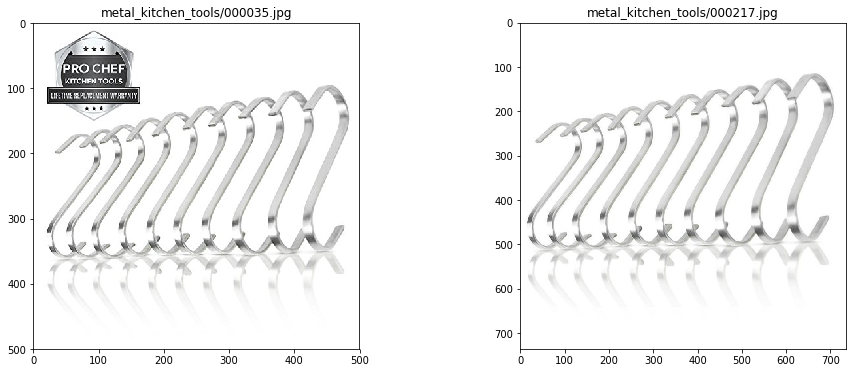

In [178]:
min_idx = 1000
num_pairs = 1
max_idx = min_idx + num_pairs
ncols = 2
nrows = num_pairs
fig, axs = plt.subplots(nrows, ncols,
                        figsize=(16, 6 * nrows), squeeze=False)

for i in range(num_pairs):
    i1, i2 = to_pair_idxs(b[min_idx + i * 2])
    img1 = imread(filepaths[i1])
    img2 = imread(filepaths[i2])
    axs[i][0].imshow(img1)
    axs[i][1].imshow(img2)
    axs[i][0].set_title(filepaths[i1][-30:])
    axs[i][1].set_title(filepaths[i2][-30:])

In [163]:
output_1 = "./duplicate_1.csv"
output_2 = "./duplicate_2.csv"
with open(output_1, "wt") as f1, \
        open(output_2, "wt") as f2:

    for i in range(2000):
        i1, i2 = to_pair_idxs(b[i * 2])
        split_path = filepaths[i1].split("/")
        re = "TRASH_DATASET_[re]" in split_path
        t = next(i for i, v in enumerate(split_path)if "TRASH_DATASET" in v)
        num = int(split_path[t + 1][:2])

        if not re or num > 10:
            f = f2
        else:
            f = f1
        f.writelines("{},{},{}\n".format(ds[b[i * 2]], filepaths[i1], filepaths[i2]))

# Remove duplications

In [166]:
import pandas as pd

In [169]:
df = pd.read_csv(output_2, header=None)

In [170]:
df.head()

,0,1,2
0,-0.002930,/home/ubuntu/github/ai/recycle/data/raw/merged...,/home/ubuntu/github/ai/recycle/data/raw/merged...
1,-0.001953,/home/ubuntu/github/ai/recycle/data/raw/merged...,/home/ubuntu/github/ai/recycle/data/raw/merged...
2,-0.001465,/home/ubuntu/github/ai/recycle/data/raw/merged...,/home/ubuntu/github/ai/recycle/data/raw/merged...
3,-0.000977,/home/ubuntu/github/ai/recycle/data/raw/merged...,/home/ubuntu/github/ai/recycle/data/raw/merged...
4,-0.000977,/home/ubuntu/github/ai/recycle/data/raw/merged...,/home/ubuntu/github/ai/recycle/data/raw/merged...


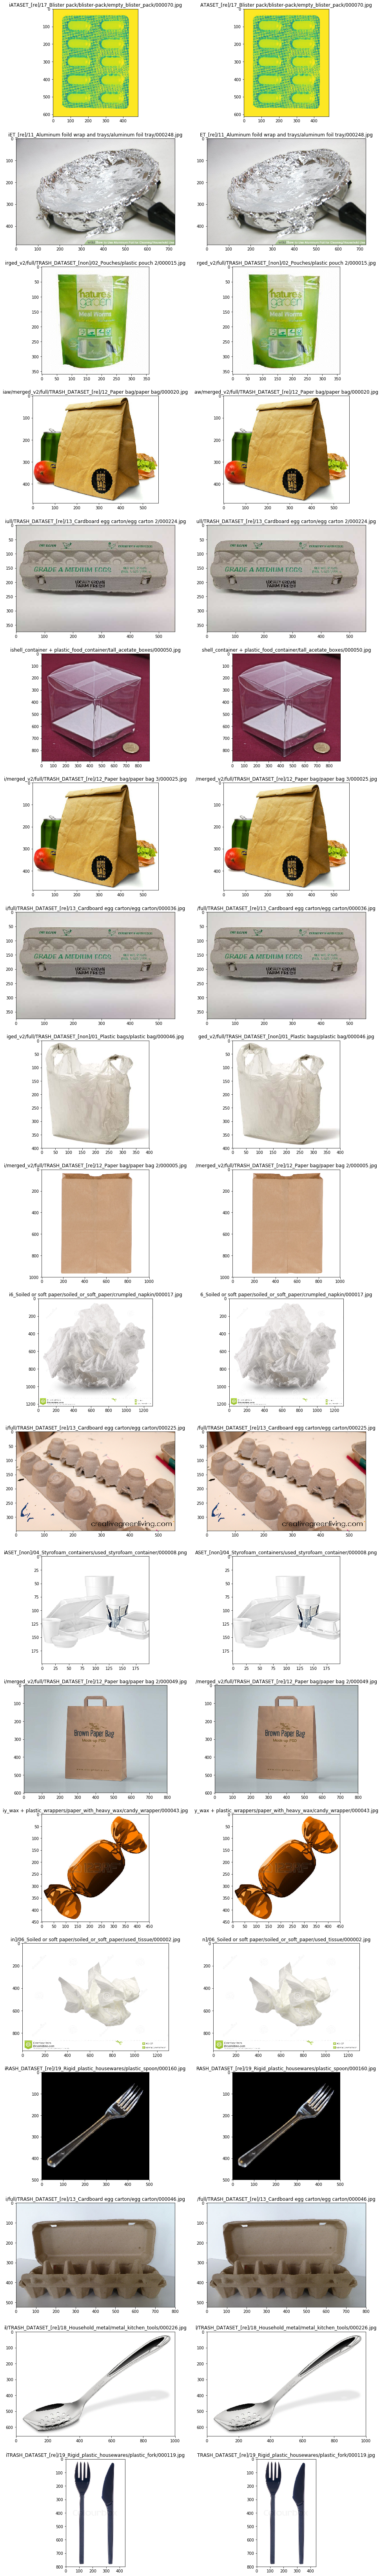

In [185]:
min_idx = 0
num_pairs = 20
max_idx = min_idx + num_pairs
ncols = 2
nrows = num_pairs
fig, axs = plt.subplots(nrows, ncols,
                        figsize=(16, 6 * nrows), squeeze=False)

for i in range(min_idx, min_idx + num_pairs):
    path1 = df.iloc[i][1]
    path2 = df.iloc[i][1]
    img1 = imread(path1)
    img2 = imread(path2)
    axs[i][0].imshow(img1)
    axs[i][1].imshow(img2)
    axs[i][0].set_title("i" + path1[-70:])
    axs[i][1].set_title(path2[-70:])